# SVM & LR Classification

## Introduction
This project will explore predictive analysis using logistic regression and support vector machine. The basic approach to the data mining project loosely follows the CRISP-DM outline.

For this mini-lab assignment, our team has once again selected the Bureau of Transportation Statistics (BTS) "Airline On-Time Performance Data" that contains arrival performance data for US carriers that contributed at least one percent of the total domestic scheduled-service passenger revenues. BTS publishes the dataset for each month in csv format, so we downloaded 12 separate files to get annual data for continuous 12-month period ending September 2015.

The dataset is quite large and for this project the dataset was reduced to six variables. These six variables are used to create train and test the model. There are as follows:


|Variable|Definition|
|------|------|
|ArrDel15 (Response)  |Arrival Delay Indicator, 15 Minutes or More (1=Yes, 0=No)|
|Carrier |Code assigned by IATA and commonly used to identify a carrier|
|ArrTimeBlk |CRS Arrival Time Block, Hourly Intervals|
|Distance |Distance between airports (miles)|
|DayofWeek |Day of Week|
|DayofMonth |Day of Month|

________

In [3]:
%reset
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn import metrics
from sklearn.cross_validation import cross_val_score

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


________
Build the dataset from the individual csv files

In [4]:
# Edit path to location of csv files
path =r'C:\Users\Mike Sylvester\Box Sync\DataMining_Lab'
allFiles = glob.glob(path + "/*.csv")

In [5]:
# Read in all csv files and create a single csv file for later use
frame = pd.DataFrame()
list_ = []
for file_ in allFiles:
    frame = pd.read_csv(file_,index_col=None, header=0,low_memory=False)
    frame1 = frame[list(frame.columns[0:11])]
    frame2 = frame.iloc[:,[14]]
    frame3 = frame.iloc[:,[23]]
    frame4 = frame[list(frame.columns[42:61])]
    frame = pd.concat([frame1, frame2, frame3, frame4], axis=1, join_axes=[frame1.index], ignore_index=True)
    list_.append(frame)

frame = pd.concat(list_, ignore_index=True)    
frame.columns = ['Year', 'Quarter', 'Month', 'DayofMonth', 'DayOfWeek', 'FlightDate', 'Carrier', 'AirlineID',
                 'Carrier2', 'TailNum', 'FlightNum', 'Origin', 'Dest', 'ArrDelay', 'ArrDelayMinutes', 'ArrDel15',
                 'ArrivalDelayGroups', 'ArrTimeBlk', 'Cancelled', 'CancellationCode', 'Diverted', 'CRSElapsedTime',
                 'ActualElapsedTime', 'AirTime', 'Flights', 'Distance', 'DistanceGroup', 'CarrierDelay',
                 'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay']

frame.to_csv(r'C:\Users\Mike Sylvester\Box Sync\DataMining_Lab\data\out2.csv', sep='\t')

In [4]:
# Edit path to location of Output csv file
df = pd.read_csv(r'C:\Users\Mike Sylvester\Box Sync\DataMining_Lab\data\out2.csv', sep='\t', low_memory=False)

________
Dataset cleanup - remove cancelled flights from the dataset

In [6]:
#Remove cancelled flights
NonCancelled = frame.loc[(frame['Cancelled']==0), ['Carrier', 'ArrTimeBlk', 'Distance', 'DayOfWeek', 'DayofMonth', 'ArrDel15']]
NonCancelled.head(20)

,Carrier,ArrTimeBlk,Distance,DayOfWeek,DayofMonth,ArrDel15
0,DL,1000-1059,731.0,4,23,0.0
1,DL,1500-1559,373.0,4,23,0.0
2,DL,0700-0759,488.0,4,23,0.0
3,DL,2100-2159,689.0,4,23,0.0
4,DL,1700-1759,240.0,4,23,1.0
5,DL,2000-2059,240.0,4,23,1.0
6,DL,1800-1859,908.0,4,23,0.0
7,DL,1300-1359,152.0,4,23,0.0
8,DL,1500-1559,152.0,4,23,0.0
9,DL,0700-0759,481.0,4,23,0.0


________
List the number of flights by carrier to further reduce the dataset

In [7]:
# Count number of noncancelled flights by carrier
CarrierFlights = pd.value_counts(NonCancelled['Carrier'].values, sort=True)
print (CarrierFlights)

WN    1226297
DL     857950
AA     621937
EV     584915
OO     580624
UA     501103
MQ     306008
US     297024
B6     257918
AS     169067
F9      90027
NK      84680
HA      76435
VX      59451
FL      11514
dtype: int64


________
Select the top 5 carriers as listed above to 
(a) reduce size of dataset and 
(b) reduce number of categorical variables needed for analysis

In [8]:
#Select top 5 carriers by flight
# APCarrier = frame.loc[(frame['APCombo']=='SAN-ATL')|(frame['APCombo']=='CHS-ATL')|(frame['APCombo']=='HNL-OGG'), ['Carrier','APCombo','ArrDel15']]
NonCancelled5 = NonCancelled.loc[(NonCancelled['Carrier']=='WN')|(NonCancelled['Carrier']=='DL')|(NonCancelled['Carrier']=='AA')|(NonCancelled['Carrier']=='OO')|(NonCancelled['Carrier']=='EV'), ['Carrier', 'ArrTimeBlk', 'Distance', 'DayOfWeek', 'DayofMonth', 'ArrDel15']]
NonCancelled5.head()

,Carrier,ArrTimeBlk,Distance,DayOfWeek,DayofMonth,ArrDel15
0,DL,1000-1059,731.0,4,23,0.0
1,DL,1500-1559,373.0,4,23,0.0
2,DL,0700-0759,488.0,4,23,0.0
3,DL,2100-2159,689.0,4,23,0.0
4,DL,1700-1759,240.0,4,23,1.0


________
Prepare dataset for logistic regression

In [18]:
# Removes ArrDel15 from working data frame
NonCancelled5 = NonCancelled5[np.isfinite(NonCancelled5['ArrDel15'])]
df_X = NonCancelled5[['Carrier', 'ArrTimeBlk', 'Distance', 'DayOfWeek', 'DayofMonth']]
NonCancelled5['ArrDel15'] = NonCancelled5['ArrDel15'].astype(np.bool)

In [19]:
# Converts categorical variable Carrier to binary
tmp_df = pd.get_dummies(df_X.Carrier,prefix='Carrier')
df_imputed = pd.concat((df_X,tmp_df),axis=1) # add back into the dataframe
df_X = df_imputed.drop('Carrier', axis=1)
df_X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3861545 entries, 0 to 5812916
Data columns (total 9 columns):
ArrTimeBlk    object
Distance      float64
DayOfWeek     int64
DayofMonth    int64
Carrier_AA    float64
Carrier_DL    float64
Carrier_EV    float64
Carrier_OO    float64
Carrier_WN    float64
dtypes: float64(6), int64(2), object(1)
memory usage: 294.6+ MB


In [20]:
# Converts categorical variable ArrTimeBlck to binary
tmp_df = pd.get_dummies(df_X.ArrTimeBlk,prefix='ArrTimeBlk')
df_imputed = pd.concat((df_X,tmp_df),axis=1) # add back into the dataframe
df_X = df_imputed.drop('ArrTimeBlk', axis=1)
df_X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3861545 entries, 0 to 5812916
Data columns (total 27 columns):
Distance                float64
DayOfWeek               int64
DayofMonth              int64
Carrier_AA              float64
Carrier_DL              float64
Carrier_EV              float64
Carrier_OO              float64
Carrier_WN              float64
ArrTimeBlk_0001-0559    float64
ArrTimeBlk_0600-0659    float64
ArrTimeBlk_0700-0759    float64
ArrTimeBlk_0800-0859    float64
ArrTimeBlk_0900-0959    float64
ArrTimeBlk_1000-1059    float64
ArrTimeBlk_1100-1159    float64
ArrTimeBlk_1200-1259    float64
ArrTimeBlk_1300-1359    float64
ArrTimeBlk_1400-1459    float64
ArrTimeBlk_1500-1559    float64
ArrTimeBlk_1600-1659    float64
ArrTimeBlk_1700-1759    float64
ArrTimeBlk_1800-1859    float64
ArrTimeBlk_1900-1959    float64
ArrTimeBlk_2000-2059    float64
ArrTimeBlk_2100-2159    float64
ArrTimeBlk_2200-2259    float64
ArrTimeBlk_2300-2359    float64
dtypes: float64(25), int64(

In [21]:
y = NonCancelled5['ArrDel15'].values
X = df_X.values

In [22]:
from sklearn.cross_validation import ShuffleSplit

num_cv_iterations = 3
num_instances = len(y)
cv_object = ShuffleSplit(n=num_instances,
                         n_iter=num_cv_iterations,
                         test_size  = 0.2)
                         
print (cv_object)

ShuffleSplit(3861545, n_iter=3, test_size=0.2, random_state=None)


________
**Resubmission Info **

Added a subsampling of data for the latter SVM models. This was required because the dataset is extremely large and
takes a very long time to run in its entirety

In [23]:
num_cv_iterations = 3
num_instances = len(y)
sm_cv_object = ShuffleSplit(n=num_instances,
                         n_iter=num_cv_iterations,
                         test_size=5000,train_size=20000)
                         
print (sm_cv_object)

ShuffleSplit(3861545, n_iter=3, test_size=5000, random_state=None)


# Run Logistic Regression

In [24]:
# run logistic regression and vary some parameters
from sklearn.linear_model import LogisticRegression
from sklearn import metrics as mt

# first we create a reusable logisitic regression object
#   here we can setup the object with different learning parameters and constants
lr_clf = LogisticRegression(penalty='l2', C=1.0, class_weight='balanced') # get object

# now we can use the cv_object that we setup before to iterate through the 
# different training and testing sets. Each time we will reuse the logisitic regression 
# object, but it gets trained on different data each time we use it.

iter_num=0
# the indices are the rows used for training and testing in each iteration
for train_indices, test_indices in cv_object: 
    X_train = X[train_indices]
    y_train = y[train_indices]
    
    X_test = X[test_indices]
    y_test = y[test_indices]
# I will create new variables here so that it is more obvious what 
# the code is doing (you can compact this syntax and avoid duplicating memory,
# but it makes this code less readable)
    
# train the reusable logisitc regression model on the training data
    lr_clf.fit(X_train,y_train)  # train object
    y_hat = lr_clf.predict(X_test) # get test set precitions

# now let's get the accuracy and confusion matrix for this iterations of training/testing
    acc = mt.accuracy_score(y_test,y_hat)
    conf = mt.confusion_matrix(y_test,y_hat)
    print ("====Iteration",iter_num," ====")
    print ("accuracy", acc )
    print ("confusion matrix\n",conf)
    iter_num+=1
    
# Also note that every time you run the above code
#   it randomly creates a new training and testing set, 
#   so accuracy will be different each time

('====Iteration', 0, ' ====')
('accuracy', 0.57685589576192953)
('confusion matrix\n', array([[352928, 274435],
       [ 52363,  92583]]))
('====Iteration', 1, ' ====')
('accuracy', 0.57541864719950175)
('confusion matrix\n', array([[351555, 275721],
       [ 52187,  92846]]))
('====Iteration', 2, ' ====')
('accuracy', 0.5759184471500397)
('confusion matrix\n', array([[351833, 275243],
       [ 52279,  92954]]))


Performance: 1:11 / 1:07 / 1:09
Logistic regression execution took an average of one minute, 9 seconds to generate 3 output matrices.
Original cost of 1.0 yielded accuracy average of 0.5756

________
Interactively adjust the cost parameter

In [25]:
# here we can change some of the parameters interactively
from ipywidgets import widgets as wd

def lr_explor(cost):
    lr_clf = LogisticRegression(penalty='l2', C=cost, class_weight='balanced') # get object
    accuracies = cross_val_score(lr_clf,X,y=y,cv=cv_object) # this also can help with parallelism
    print(accuracies)

wd.interact(lr_explor,cost=(0.001,5.0,0.05))

[ 0.57577213  0.57546008  0.57549893]


Trial results:

0.201 [ 0.57701275  0.57649318  0.57623339]

5.001 [ 0.57686001  0.57743311  0.57689787]

10.301 [ 0.57612374  0.57632217  0.57595403]

19.151 [ 0.57528172  0.57631955  0.57529869]

49.951 [ 0.57608979  0.57544098  0.57648665]

100 [ 0.57690179  0.57518511  0.57553367]

Changes to cost did not yield any significant differences in accuracy

________
# Weight Interpretation

#### Resubmission Info 

Corrected the spurious model by adding the class_weight parameter. We selected the "balanced" mode that 
uses the values of y to automatically adjust weights.

In [26]:
from sklearn.preprocessing import StandardScaler

# we want to normalize the features based upon the mean and standard deviation of each column. 
# However, we do not want to accidentally use the testing data to find out the mean and std (this would be snooping)
# to Make things easier, let's start by just using whatever was last stored in the variables:
##    X_train , y_train , X_test, y_test (they were set in a for loop above)

# scale attributes by the training set
scl_obj = StandardScaler()
scl_obj.fit(X_train) # find scalings for each column that make this zero mean and unit std
# the line of code above only looks at training data to get mean and std and we can use it 
# to transform new feature data

X_train_scaled = scl_obj.transform(X_train) # apply to training
X_test_scaled = scl_obj.transform(X_test) # apply those means and std to the test set (without snooping at the test set values)

# train the model just as before
lr_clf = LogisticRegression(penalty='l2', C=0.05, class_weight='balanced') # get object, the 'C' value is less (can you guess why??)
lr_clf.fit(X_train_scaled,y_train)  # train object

y_hat = lr_clf.predict(X_test_scaled) # get test set precitions

acc = mt.accuracy_score(y_test,y_hat)
conf = mt.confusion_matrix(y_test,y_hat)
print('accuracy:', acc )
print(conf )

# sort these attributes and spit them out
zip_vars = zip(lr_clf.coef_.T,df_imputed.columns) # combine attributes
# sorted(zip_vars, key = lambda t: np.abs(t[0])) # sort them by the magnitude of the weight
for coef, name in zip_vars:
    print(name, 'has weight of', coef[0]) # now print them out

('accuracy:', 0.57591197305741615)
[[351827 275249]
 [ 52278  92955]]
('ArrTimeBlk', 'has weight of', -0.02637215346261422)
('Distance', 'has weight of', -0.06159543809553731)
('DayOfWeek', 'has weight of', -0.06740970611784633)
('DayofMonth', 'has weight of', 0.032589403010006089)
('Carrier_AA', 'has weight of', -0.15124411580086491)
('Carrier_DL', 'has weight of', 0.060278100957759657)
('Carrier_EV', 'has weight of', 0.038952718469151902)
('Carrier_OO', 'has weight of', 0.033008374070916495)
('Carrier_WN', 'has weight of', 0.05373271689494194)
('ArrTimeBlk_0001-0559', 'has weight of', -0.086292212022160475)
('ArrTimeBlk_0600-0659', 'has weight of', -0.18175203742961346)
('ArrTimeBlk_0700-0759', 'has weight of', -0.16007289997431329)
('ArrTimeBlk_0800-0859', 'has weight of', -0.15089555018761278)
('ArrTimeBlk_0900-0959', 'has weight of', -0.10242277407648075)
('ArrTimeBlk_1000-1059', 'has weight of', -0.089244137787575867)
('ArrTimeBlk_1100-1159', 'has weight of', -0.06532526182183882

________
Graphical ouptut of weights

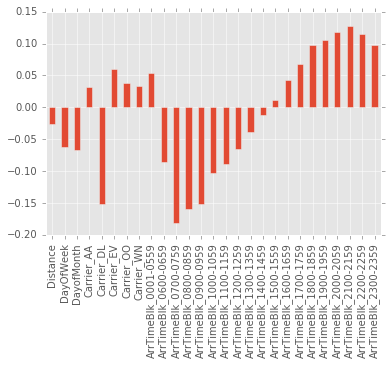

In [30]:
from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use('ggplot')


weights = pd.Series(lr_clf.coef_[0],index=df_X.columns)
weights.plot(kind='bar')
plt.show()

Interpretation: Time of day (ArrTimeBlk) appears to be the most important variable in predicting if a flight will be delayed.
Flights arriving after 3 pm have an increased weight while those arriving before noon have a decreasing weight the earlier in 
the day they arrive.  Of the top five carriers, four were closely weighted together between .025 and .05 but Delta was an 
outlier at -0.15.  Flight distance, day of week, and day of month were all around -0.05, making them less important than arrival block.

# Support Vector Machine

In [31]:
# use some compact notation for creating a linear SVM classifier with stichastic descent
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier

regularize_const = 0.1
iterations = 5
svm_sgd = SGDClassifier(alpha=regularize_const,
        fit_intercept=True, l1_ratio=0.0, learning_rate='optimal',
        loss='hinge', n_iter=iterations, n_jobs=-1, penalty='l2', class_weight='balanced')

scl = StandardScaler()
for train_idx, test_idx in cv_object:
    svm_sgd.fit(scl.fit_transform(X[train_idx]),y[train_idx])
    yhat = svm_sgd.predict(scl.transform(X[test_idx]))
    
    conf = mt.confusion_matrix(y[test_idx],yhat)
    acc = mt.accuracy_score(y[test_idx],yhat)

print ('Confusion:', conf)
print ('SVM:', acc)


('Confusion:', array([[350553, 276396],
       [ 54613,  90747]]))
('SVM:', 0.57140341495437708)


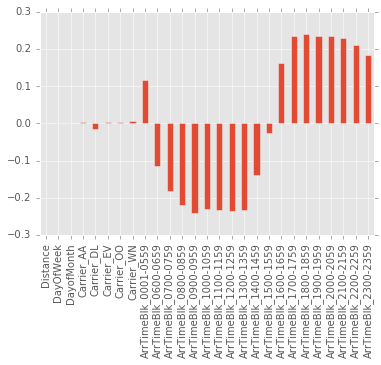

In [32]:
from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use('ggplot')


weights = pd.Series(svm_sgd.coef_[0],index=df_X.columns)
weights.plot(kind='bar')
plt.show()

#### Resubmission Info 
The SVM (stochastic gradient descent) weights are similar to the logistic regression weights. However, a few of the
vectors such as carrier and day of the week become less important.

In this model logistic regression and SVM perform equally as well. However, SVM (stochastic gradient descent) is more efficient and runs significantly faster which should be a consideration.

Performance: :26 / :28 / :26 SVM required an average of 27 to return an average for five iterations. SVM performed in roughly 1/3 the amount of time as Logistic Regression even while doing more iterations. Logistic regression had a slighly higher accuracy weight than SVM (0.5756 versus 0.5464)

________
#### Resubmission Info 

Added SVM kernels: RBF and linear

These SVM models were run using a subsampling of data. The test and training datasets were defined with 5000 and 20000
rows, respectively. These SVM models did not consistently outperform the logistic regression model. Some of the
iterations were above 58% but on average they fell short of the logistic regression model.

In [33]:
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

iter_num=0
regularize_const = 0.1
iterations = 3

for kernel in ('rbf', 'linear'):

    print ("Kernel: " + kernel)    
    svm_clf = SVC(C=1, kernel=kernel, gamma=.001, class_weight='balanced')           

    scl = StandardScaler()
    for train_idx, test_idx in sm_cv_object:
        svm_clf.fit(scl.fit_transform(X[train_idx]),y[train_idx])
        yhat = svm_clf.predict(scl.transform(X[test_idx]))   


        conf = mt.confusion_matrix(y[test_idx],yhat)
        acc = mt.accuracy_score(y[test_idx],yhat)

        print ("====Iteration",iter_num," ====")
        print ("accuracy", acc)
        print ("confusion matrix\n",conf)
        iter_num+=1


Kernel: rbf
('====Iteration', 0, ' ====')
('accuracy', 0.53459999999999996)
('confusion matrix\n', array([[2051, 2033],
       [ 294,  622]]))
('====Iteration', 1, ' ====')
('accuracy', 0.57440000000000002)
('confusion matrix\n', array([[2266, 1776],
       [ 352,  606]]))
('====Iteration', 2, ' ====')
('accuracy', 0.56520000000000004)
('confusion matrix\n', array([[2244, 1851],
       [ 323,  582]]))
Kernel: linear
('====Iteration', 3, ' ====')
('accuracy', 0.58160000000000001)
('confusion matrix\n', array([[2295, 1753],
       [ 339,  613]]))
('====Iteration', 4, ' ====')
('accuracy', 0.55679999999999996)
('confusion matrix\n', array([[2202, 1856],
       [ 360,  582]]))
('====Iteration', 5, ' ====')
('accuracy', 0.53239999999999998)
('confusion matrix\n', array([[1976, 2005],
       [ 333,  686]]))


________
#### Resubmission Info 

Analyze the rbf kernel SVC support vectors

The support vectors match the stochastic gradient decent but are much different than the logistic regression support
vectors. These indicate the time of day (ArrTimeBlk) to be the most important variable in predicting if a flight will be delayed. The others such as the carrier are less important.

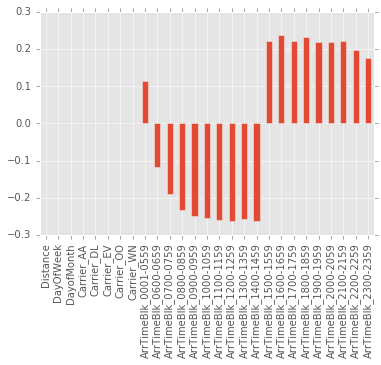

In [34]:
from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use('ggplot')


weights = pd.Series(svm_clf.coef_[0],index=df_X.columns)
weights.plot(kind='bar')
plt.show()

## Final Conclusions:

With exception to the support vectors the differences between the logistic regression and SVM were insignificant as 
both had an accuracy of ~58%. The logistic regression model was able to run fairly efficiently on the entire dataset but the SVM models required a subset of the data. Therefore, based on these efficiencies the logistic regression model is the preferred choice.
